In [18]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

In [19]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 'r_rcs_flux_corr',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [20]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")

In [21]:
X = data[features_num]
y = data[np.append(y_column, ['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN'])]

In [22]:
# Creating new features
columns = X.columns
for i in range(len(columns)):
    if columns[i]!='Z_BEST':
        for j in range(i+1, len(columns)):
            if columns[j]!='Z_BEST':
                X[f"{columns[i]}/{columns[j]}"] = X[columns[i]]/X[columns[j]]
                X[f"{columns[i]}-{columns[j]}"] = X[columns[i]]-X[columns[j]]

/var/lib/condor/execute/dir_1924914/ipykernel_1924950/2770299810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{columns[i]}/{columns[j]}"] = X[columns[i]]/X[columns[j]]
/var/lib/condor/execute/dir_1924914/ipykernel_1924950/2770299810.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{columns[i]}-{columns[j]}"] = X[columns[i]]-X[columns[j]]
/var/lib/condor/execute/dir_1924914/ipykernel_1924950/2770299810.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

In [23]:
le = LabelEncoder()
labels = np.unique(y[y_column].astype(str))
y[y_column] = le.fit_transform(y[y_column])

/var/lib/condor/execute/dir_1924914/ipykernel_1924950/2925652128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y_column] = le.fit_transform(y[y_column])


In [24]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y['Classification'], random_state=42)

y_train_flags = y_train[['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN']]
y_test_flags = y_test[['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN']]

y_train = y_train.drop(columns=['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN'])
y_test = y_test.drop(columns=['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN'])

In [56]:
np.savetxt("../../../Data/Other/Generated/Index_to_generate_data.csv", y_train.index)

# Loading generated data and just adding it to the training set

Do not load these cells if you just want to run the training set

In [109]:
generated_data = pd.read_csv("../../../Data/Other/Generated/Generated_data.csv")

In [110]:
X_generated = generated_data[features_num]
y_generated = generated_data[y_column]

In [111]:
# Labeling the y-column
y_generated = le.transform(y_generated)

In [112]:
# Appending y to training data
y_train = pd.concat([y_train, pd.DataFrame(y_generated, columns=['Classification'])])

In [113]:
# Appending generated data to the train data
X_train = pd.concat([X_train, X_generated])

# Scaling

## Local scaling

In [100]:
# Standard scaling the numerical data
scaler = MinMaxScaler()

# Transforming the categorical data
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

## Global scaling

In [63]:
# Scaling by using a global max and min (except for the redshift)

# Transforming the redshift
z_max = max(X_train['Z_BEST'])
z_min = min(X_train['Z_BEST'])

X_train['Z_BEST'] = (X_train['Z_BEST'] - z_min)/(z_max - z_min)
X_test['Z_BEST'] = (X_test['Z_BEST'] - z_min)/(z_max - z_min)

# Transforming the other data
flux_columns = X_train.loc[:, X_train.columns != 'Z_BEST']

flux_max = np.nanmax(X_train.loc[:, X_train.columns != 'Z_BEST'].to_numpy())
flux_min = np.nanmin(X_train.loc[:, X_train.columns != 'Z_BEST'].to_numpy())
X_train.loc[:, X_train.columns != 'Z_BEST'] = (flux_columns - flux_min)/(flux_max - flux_min)
X_test.loc[:, X_test.columns != 'Z_BEST'] = (X_test.loc[:, X_test.columns != 'Z_BEST'] - flux_min)/(flux_max - flux_min)


## Semi-global scaling

In [43]:
# Scaling by using semi-global max and min per group

groups = [
    ['Total_flux', 'Peak_flux'],
    ['F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350', 'F_SPIRE_500'],
    ['I_flux_corr', 'z_flux_corr', 'y_flux_corr', 'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 
           'Ks_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr'],
    ['NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 
           'R_flux_corr', 'r_rcs_flux_corr', 'g_flux_corr', 
           'nb921_hsc_flux_corr'],
    ['Z_BEST']
]

for group in groups:
    global_max = np.nanmax(X_train[group].to_numpy())
    global_min = np.nanmin(X_train[group].to_numpy())
    
    X_train[group] = (X_train[group] - global_min)/(global_max - global_min)
    X_test[group] = (X_test[group] - global_min)/(global_max - global_min)

# Weights

In [9]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Oversampling/Undersampling

In [14]:
imp_mean = SimpleImputer(strategy='mean')


X_train = imp_mean.fit_transform(X_train)
X_test = imp_mean.transform(X_test)

In [73]:
X_train_resampled, y_train_resampled = BorderlineSMOTE(k_neighbors=5, m_neighbors=10, 
                                                       n_jobs=8).fit_resample(X_train, y_train)

In [115]:
y_train.value_counts()

Classification
2                 170934
0                 162976
1                 160362
3                  45325
dtype: int64

# Flaml

### Optional: load log

# Running FLAML on various gradient boosted decisions trees

### Gradient boosted

In [29]:
from flaml import AutoML
automl = AutoML()

#### Training the model

In [31]:
import warnings

estimators = ['lgbm', 'xgboost', 'xgb_limitdepth']
#estimators = ['extra_tree']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    automl.fit(X_train, y_train.to_numpy(), task="classification", metric='accuracy',
                                #X_val=X_test , y_val=y_test.to_numpy(),
                                #ensemble=True,
                                estimator_list=estimators, time_budget=3600*10, n_jobs=64, 
                                log_file_name='general_extra_features2.log',
                                #starting_points=automl.best_config_per_estimator
              )

[flaml.automl: 09-04 11:05:38] {2390} INFO - task = classification
[flaml.automl: 09-04 11:05:39] {2392} INFO - Data split method: stratified
[flaml.automl: 09-04 11:05:39] {2396} INFO - Evaluation method: cv
[flaml.automl: 09-04 11:05:39] {2465} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 09-04 11:05:39] {2605} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth']
[flaml.automl: 09-04 11:05:39] {2897} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-04 11:05:47] {3025} INFO - Estimated sufficient time budget=81399s. Estimated necessary time budget=542s.
[flaml.automl: 09-04 11:05:47] {3072} INFO -  at 16.4s,	estimator lgbm's best error=0.2624,	best estimator lgbm's best error=0.2624
[flaml.automl: 09-04 11:05:47] {2897} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-04 11:05:56] {3072} INFO -  at 25.4s,	estimator lgbm's best error=0.2624,	best estimator lgbm's best error=0.2624
[flaml.automl: 09-04 11:05:56] {2897} INFO - i

[flaml.automl: 09-04 11:26:33] {2897} INFO - iteration 36, current learner lgbm
[flaml.automl: 09-04 11:35:24] {3072} INFO -  at 1793.4s,	estimator lgbm's best error=0.0938,	best estimator lgbm's best error=0.0938
[flaml.automl: 09-04 11:35:24] {2897} INFO - iteration 37, current learner xgb_limitdepth
[flaml.automl: 09-04 11:36:13] {3072} INFO -  at 1842.1s,	estimator xgb_limitdepth's best error=0.1160,	best estimator lgbm's best error=0.0938
[flaml.automl: 09-04 11:36:13] {2897} INFO - iteration 38, current learner xgb_limitdepth
[flaml.automl: 09-04 11:36:54] {3072} INFO -  at 1883.5s,	estimator xgb_limitdepth's best error=0.1160,	best estimator lgbm's best error=0.0938
[flaml.automl: 09-04 11:36:54] {2897} INFO - iteration 39, current learner xgb_limitdepth
[flaml.automl: 09-04 11:37:43] {3072} INFO -  at 1932.5s,	estimator xgb_limitdepth's best error=0.1102,	best estimator lgbm's best error=0.0938
[flaml.automl: 09-04 11:37:43] {2897} INFO - iteration 40, current learner xgb_limit

KeyboardInterrupt: 

In [ ]:
'num_class':4,
             'max_depth': 7, 
             'eta': 0.05,
             'tree_method':'hist',
             #reg_alpha=0.5,   
             'min_child_weight':0.5, 
             #'colsample_bylevel':0.5,
             #'colsample_bytree':0.5,
             #reg_lambda=3,
             'nthread': 4,
             'objective':'multi:softprob',

In [32]:
import warnings
from ray import tune

# Purely Xgboost limit

# Setting custom search space
custom_hp = {
    "xgb_limitdepth": {
        "max_depth": {
            "domain": tune.choice([7, 8, 9, 10 , 11]),
            "low_cost_init_value": 8,
        },
        "eta":{
            "domain": 0.1
        },
        "reg_alpha":{
            "domain": tune.uniform(0, 10),
            "low_cost_init_value": 5,
        },
        "reg_lambda":{
            "domain": tune.uniform(0, 20),
            "low_cost_init_value": 10,
        },
        "gamma":{
           "domain": tune.loguniform(0, 2),
           "low_cost_init_value": 0, 
        }
        
        
    }
}

estimators = ['xgb_limitdepth']
#estimators = ['extra_tree']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    automl.fit(X_train, y_train.to_numpy(), task="classification", metric='accuracy',
                                estimator_list=estimators, time_budget=600, n_jobs=4, 
                                log_file_name='xgboost.log',
                                custom_hp=custom_hp
              )

ModuleNotFoundError: No module named 'ray'

#### Loading model from log file if the jupyter notebook was reloaded

In [19]:
automl.retrain_from_log(log_file_name='general.log', X_train=X_train, y_train=y_train.to_numpy(), 
                          task="classification", eval_method='cv', n_splits=128,
                         n_jobs=4)

12522.272614955902

In [21]:
automl

AutoML(append_log=False, auto_augment=True, custom_hp={}, early_stop=False,
       ensemble=False, estimator_list='auto', eval_method='auto',
       fit_kwargs_by_estimator={'xgb_limitdepth': {}}, hpo_method='auto',
       keep_search_state=False, learner_selector='sample', log_file_name='',
       log_training_metric=False, log_type='better', max_iter=None,
       mem_thres=4294967296, metric='auto', metric_constraints=[],
       min_sample_size=10000, model_history=False, n_concurrent_trials=1,
       n_jobs=-1, n_splits=5, pred_time_limit=inf, retrain_full=True,
       sample=True, split_ratio=0.1, split_type='auto',
       starting_points='static', task='classification', ...)

#### Statistics of model

In [109]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 1975, 'num_leaves': 50, 'min_child_samples': 7, 'learning_rate': 0.08147285979384909, 'log_max_bin': 10, 'colsample_bytree': 0.8109724192136218, 'reg_alpha': 0.0009765625, 'reg_lambda': 9.434049732302569}
Best accuracy on validation data: 0.9101
Training duration of best run: 400.9 s


In [110]:
best_config_per_estimator=automl.best_config_per_estimator
print('Best ML leaner per estimator:', best_config_per_estimator)

Best ML leaner per estimator: {'lgbm': {'n_estimators': 1975, 'num_leaves': 50, 'min_child_samples': 7, 'learning_rate': 0.08147285979384909, 'log_max_bin': 10, 'colsample_bytree': 0.8109724192136218, 'reg_alpha': 0.0009765625, 'reg_lambda': 9.434049732302569}, 'xgboost': {'n_estimators': 701, 'max_leaves': 879, 'min_child_weight': 54.583175196825195, 'learning_rate': 0.1062161397302771, 'subsample': 0.991439684901562, 'colsample_bylevel': 0.7597649056708654, 'colsample_bytree': 0.5523322116093697, 'reg_alpha': 0.10703111196376883, 'reg_lambda': 71.83411599615755}, 'xgb_limitdepth': {'n_estimators': 2864, 'max_depth': 11, 'min_child_weight': 0.5925593814064807, 'learning_rate': 0.035866880330757175, 'subsample': 0.8928092890161611, 'colsample_bylevel': 0.6493559537746952, 'colsample_bytree': 0.845327293144379, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.007932674131641516}}


In [111]:
automl.best_config_per_estimator

{'lgbm': {'n_estimators': 1975,
  'num_leaves': 50,
  'min_child_samples': 7,
  'learning_rate': 0.08147285979384909,
  'log_max_bin': 10,
  'colsample_bytree': 0.8109724192136218,
  'reg_alpha': 0.0009765625,
  'reg_lambda': 9.434049732302569},
 'xgboost': {'n_estimators': 701,
  'max_leaves': 879,
  'min_child_weight': 54.583175196825195,
  'learning_rate': 0.1062161397302771,
  'subsample': 0.991439684901562,
  'colsample_bylevel': 0.7597649056708654,
  'colsample_bytree': 0.5523322116093697,
  'reg_alpha': 0.10703111196376883,
  'reg_lambda': 71.83411599615755},
 'xgb_limitdepth': {'n_estimators': 2864,
  'max_depth': 11,
  'min_child_weight': 0.5925593814064807,
  'learning_rate': 0.035866880330757175,
  'subsample': 0.8928092890161611,
  'colsample_bylevel': 0.6493559537746952,
  'colsample_bytree': 0.845327293144379,
  'reg_alpha': 0.0009765625,
  'reg_lambda': 0.007932674131641516}}

In [112]:
from flaml.data import get_output_from_log

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename="general_extra_features.log", time_budget=3600*10)

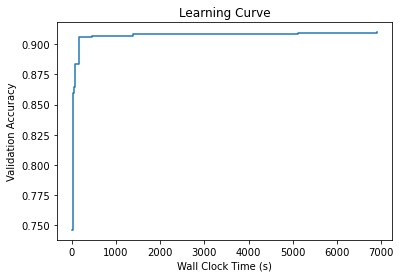

In [113]:
import matplotlib.pyplot as plt
import numpy as np

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation Accuracy")
plt.step(time_history, 1 - np.array(best_valid_loss_history), where="post")
plt.show()


In [114]:
y_pred = automl.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

           0     0.8786    0.8274    0.8522      3192
           1     0.6524    0.4114    0.5046       333
           2     0.7954    0.7037    0.7468      1718
           3     0.9303    0.9636    0.9467     14160

    accuracy                         0.9087     19403
   macro avg     0.8142    0.7265    0.7626     19403
weighted avg     0.9051    0.9087    0.9059     19403



<BarContainer object of 346 artists>

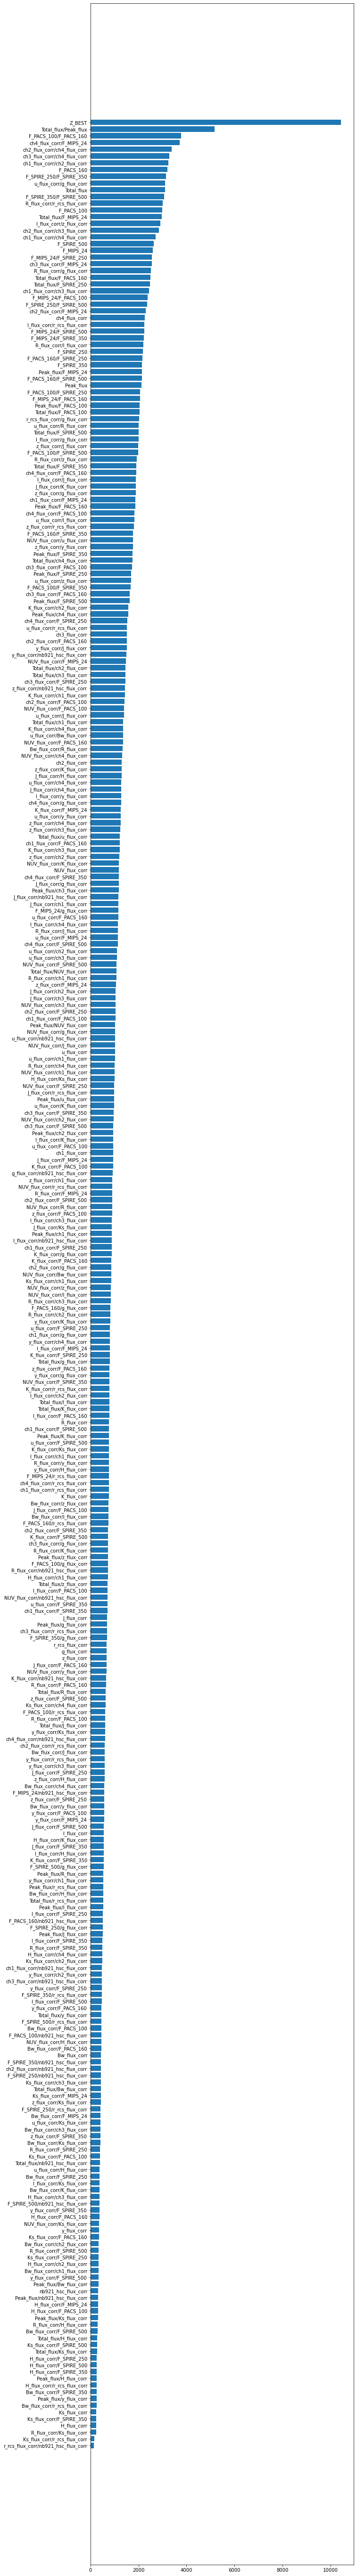

In [119]:
import matplotlib.pyplot as plt
x = [x for _, x in sorted(zip(automl.model.estimator.feature_importances_, automl.model.estimator.feature_name_))]
y = [x for _, x in sorted(zip(automl.model.estimator.feature_importances_, automl.model.estimator.feature_importances_))]

plt.figure(figsize=(10,100))
plt.barh(x, y)


# Lightgbm

In [12]:
import lightgbm as lgb
lightbm = lgb.LGBMClassifier(num_class=4, 
                             objective="multiclass",  
                             n_estimators=500, 
                             class_weight="balanced",
                            #early_stopping_round=100,
                             learning_rate=0.05,
                            reg_lambda=10,
                            #verbose=-1,
                            #max_depth=8,
                            #min_data_in_leaf=512,
                            log_max_bin=10,
                            min_child_samples=7,
                            num_leaves=50,
                            )

In [13]:
lightbm.fit(X_train, y_train, eval_set=[(X_test, y_test)])

/Users/users/karsten/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/users/karsten/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's multi_logloss: 1.30625
[2]	valid_0's multi_logloss: 1.23684
[3]	valid_0's multi_logloss: 1.17519
[4]	valid_0's multi_logloss: 1.11964
[5]	valid_0's multi_logloss: 1.07064
[6]	valid_0's multi_logloss: 1.02569
[7]	valid_0's multi_logloss: 0.985486
[8]	valid_0's multi_logloss: 0.948372
[9]	valid_0's multi_logloss: 0.913898
[10]	valid_0's multi_logloss: 0.882845
[11]	valid_0's multi_logloss: 0.854518
[12]	valid_0's multi_logloss: 0.827652
[13]	valid_0's multi_logloss: 0.802891
[14]	valid_0's multi_logloss: 0.780547
[15]	valid_0's multi_logloss: 0.758964
[16]	valid_0's multi_logloss: 0.73898
[17]	valid_0's multi_logloss: 0.720668
[18]	valid_0's multi_logloss: 0.703645
[19]	valid_0's multi_logloss: 0.687736
[20]	valid_0's multi_logloss: 0.672365
[21]	valid_0's multi_logloss: 0.658003
[22]	valid_0's multi_logloss: 0.645112
[23]	valid_0's multi_logloss: 0.632265
[24]	valid_0's multi_logloss: 0.621173
[25]	valid_0's multi_logloss: 0.610282
[26]	valid_0's multi_logloss: 0.599756
[2

[210]	valid_0's multi_logloss: 0.29444
[211]	valid_0's multi_logloss: 0.294071
[212]	valid_0's multi_logloss: 0.293839
[213]	valid_0's multi_logloss: 0.293503
[214]	valid_0's multi_logloss: 0.293283
[215]	valid_0's multi_logloss: 0.292933
[216]	valid_0's multi_logloss: 0.292614
[217]	valid_0's multi_logloss: 0.292339
[218]	valid_0's multi_logloss: 0.292045
[219]	valid_0's multi_logloss: 0.291837
[220]	valid_0's multi_logloss: 0.291591
[221]	valid_0's multi_logloss: 0.291251
[222]	valid_0's multi_logloss: 0.290934
[223]	valid_0's multi_logloss: 0.290669
[224]	valid_0's multi_logloss: 0.290246
[225]	valid_0's multi_logloss: 0.289935
[226]	valid_0's multi_logloss: 0.289641
[227]	valid_0's multi_logloss: 0.289298
[228]	valid_0's multi_logloss: 0.288947
[229]	valid_0's multi_logloss: 0.28869
[230]	valid_0's multi_logloss: 0.288368
[231]	valid_0's multi_logloss: 0.288048
[232]	valid_0's multi_logloss: 0.287754
[233]	valid_0's multi_logloss: 0.287479
[234]	valid_0's multi_logloss: 0.28729
[23

[416]	valid_0's multi_logloss: 0.258826
[417]	valid_0's multi_logloss: 0.258761
[418]	valid_0's multi_logloss: 0.258708
[419]	valid_0's multi_logloss: 0.25861
[420]	valid_0's multi_logloss: 0.258535
[421]	valid_0's multi_logloss: 0.258468
[422]	valid_0's multi_logloss: 0.258379
[423]	valid_0's multi_logloss: 0.258289
[424]	valid_0's multi_logloss: 0.258218
[425]	valid_0's multi_logloss: 0.258138
[426]	valid_0's multi_logloss: 0.258076
[427]	valid_0's multi_logloss: 0.258006
[428]	valid_0's multi_logloss: 0.257924
[429]	valid_0's multi_logloss: 0.257861
[430]	valid_0's multi_logloss: 0.257753
[431]	valid_0's multi_logloss: 0.257669
[432]	valid_0's multi_logloss: 0.257609
[433]	valid_0's multi_logloss: 0.257516
[434]	valid_0's multi_logloss: 0.257459
[435]	valid_0's multi_logloss: 0.257408
[436]	valid_0's multi_logloss: 0.257338
[437]	valid_0's multi_logloss: 0.257248
[438]	valid_0's multi_logloss: 0.257203
[439]	valid_0's multi_logloss: 0.257155
[440]	valid_0's multi_logloss: 0.25712
[4

LGBMClassifier(class_weight='balanced', learning_rate=0.05, log_max_bin=10,
               min_child_samples=7, n_estimators=500, num_class=4,
               num_leaves=50, objective='multiclass', reg_lambda=10)

In [231]:
cv_score_lgb = cross_val_score(lightbm, X_train, y_train, cv=64, n_jobs=64, scoring="accuracy")

In [232]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_lgb), 5), "±", round(np.std(cv_score_lgb), 5))

Cross-validated Accuracy: 0.87436 ± 0.01571


In [14]:
y_pred = lightbm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8280    0.8822    0.8542      3192
quasar-like radio AGN / high-excitation radio galaxy     0.6007    0.5105    0.5519       333
                                     radio-quiet AGN     0.7062    0.8114    0.7551      1718
                                 star-forming galaxy     0.9558    0.9278    0.9416     14160

                                            accuracy                         0.9029     19403
                                           macro avg     0.7727    0.7830    0.7757     19403
                                        weighted avg     0.9066    0.9029    0.9040     19403



[]

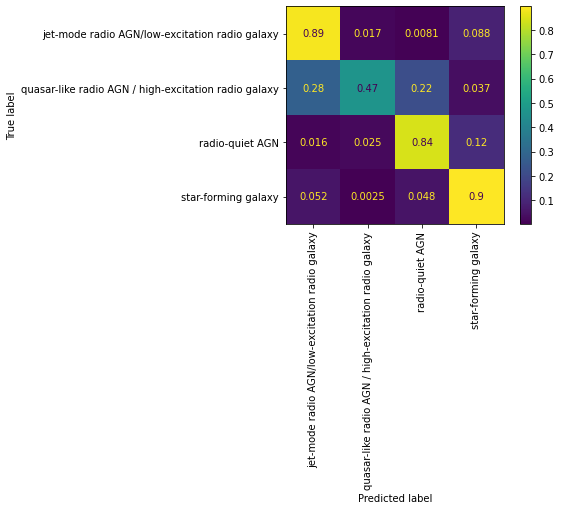

In [37]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [174]:
y_pred_xgb = model.predict(X_test)
y_pred_lgb = lightbm.predict(X_test)

In [175]:
y_pred_temp = y_pred_xgb.copy()
y_pred_temp[y_pred_temp==0] = 0
y_pred_temp[y_pred_lgb==0] = 0

In [176]:
print(classification_report(y_test, y_pred_temp, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7663    0.8842    0.8210      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5628    0.4148    0.4776       270
                                     radio-quiet AGN     0.7199    0.7942    0.7553      1356
                                 star-forming galaxy     0.9537    0.9144    0.9337     11315

                                            accuracy                         0.8902     15522
                                           macro avg     0.7507    0.7519    0.7469     15522
                                        weighted avg     0.8953    0.8902    0.8914     15522



# XGBoost

In [ ]:
model.fit(X_train, y_train.to_numpy())

## Cross-validation

In [26]:
import xgboost

# Putting the train data into a DMatrix
data = xgboost.DMatrix(X_train, y_train, nthread=4)

In [51]:
parameters = {'num_class':4,
             'max_depth': 10, 
             'eta': 0.05,
             'tree_method':'hist',
             #reg_alpha=0.5,   
             #'min_child_weight':0.5, 
             #'colsample_bylevel':0.5,
             #'colsample_bytree':0.5,
             reg_lambda: 3,
             'nthread': 4,
             'objective':'multi:softprob',
                      
             }
bst = xgboost.cv(dtrain=data, params=parameters, 
           num_boost_round=10**4, stratified=True, 
           nfold=8, early_stopping_rounds=50,
           verbose_eval=True, metrics=['merror', 'mlogloss'])

[0]	train-merror:0.13392+0.00111	train-mlogloss:1.31640+0.00008	test-merror:0.15038+0.00322	test-mlogloss:1.31802+0.00030
[1]	train-merror:0.13204+0.00097	train-mlogloss:1.25309+0.00018	test-merror:0.14842+0.00296	test-mlogloss:1.25626+0.00054
[2]	train-merror:0.13058+0.00121	train-mlogloss:1.19528+0.00025	test-merror:0.14658+0.00261	test-mlogloss:1.19991+0.00079
[3]	train-merror:0.12912+0.00080	train-mlogloss:1.14222+0.00024	test-merror:0.14559+0.00227	test-mlogloss:1.14831+0.00108
[4]	train-merror:0.12796+0.00069	train-mlogloss:1.09332+0.00021	test-merror:0.14464+0.00259	test-mlogloss:1.10078+0.00136
[5]	train-merror:0.12693+0.00075	train-mlogloss:1.04817+0.00023	test-merror:0.14425+0.00266	test-mlogloss:1.05698+0.00159
[6]	train-merror:0.12629+0.00078	train-mlogloss:1.00633+0.00029	test-merror:0.14337+0.00249	test-mlogloss:1.01640+0.00175
[7]	train-merror:0.12543+0.00080	train-mlogloss:0.96734+0.00036	test-merror:0.14327+0.00246	test-mlogloss:0.97866+0.00193
[8]	train-merror:0.12451

[67]	train-merror:0.08729+0.00023	train-mlogloss:0.29060+0.00058	test-merror:0.11997+0.00296	test-mlogloss:0.35697+0.00475
[68]	train-merror:0.08678+0.00031	train-mlogloss:0.28781+0.00058	test-merror:0.11961+0.00296	test-mlogloss:0.35496+0.00476
[69]	train-merror:0.08623+0.00040	train-mlogloss:0.28509+0.00060	test-merror:0.11906+0.00304	test-mlogloss:0.35298+0.00476
[70]	train-merror:0.08573+0.00043	train-mlogloss:0.28246+0.00066	test-merror:0.11894+0.00289	test-mlogloss:0.35109+0.00472
[71]	train-merror:0.08520+0.00044	train-mlogloss:0.27989+0.00066	test-merror:0.11875+0.00260	test-mlogloss:0.34927+0.00473
[72]	train-merror:0.08463+0.00046	train-mlogloss:0.27738+0.00066	test-merror:0.11868+0.00271	test-mlogloss:0.34749+0.00477
[73]	train-merror:0.08418+0.00055	train-mlogloss:0.27491+0.00071	test-merror:0.11851+0.00273	test-mlogloss:0.34572+0.00482
[74]	train-merror:0.08369+0.00050	train-mlogloss:0.27254+0.00074	test-merror:0.11829+0.00274	test-mlogloss:0.34404+0.00484
[75]	train-merro

[134]	train-merror:0.06130+0.00044	train-mlogloss:0.19248+0.00083	test-merror:0.10956+0.00279	test-mlogloss:0.29667+0.00493
[135]	train-merror:0.06109+0.00037	train-mlogloss:0.19175+0.00084	test-merror:0.10959+0.00287	test-mlogloss:0.29633+0.00489
[136]	train-merror:0.06081+0.00033	train-mlogloss:0.19100+0.00079	test-merror:0.10946+0.00293	test-mlogloss:0.29600+0.00486
[137]	train-merror:0.06051+0.00034	train-mlogloss:0.19023+0.00084	test-merror:0.10940+0.00278	test-mlogloss:0.29567+0.00485
[138]	train-merror:0.06030+0.00032	train-mlogloss:0.18947+0.00084	test-merror:0.10923+0.00284	test-mlogloss:0.29536+0.00485
[139]	train-merror:0.05997+0.00036	train-mlogloss:0.18869+0.00086	test-merror:0.10904+0.00274	test-mlogloss:0.29503+0.00478
[140]	train-merror:0.05973+0.00037	train-mlogloss:0.18798+0.00086	test-merror:0.10904+0.00278	test-mlogloss:0.29473+0.00475
[141]	train-merror:0.05946+0.00039	train-mlogloss:0.18722+0.00088	test-merror:0.10884+0.00301	test-mlogloss:0.29439+0.00481
[142]	tr

[201]	train-merror:0.04567+0.00056	train-mlogloss:0.15316+0.00096	test-merror:0.10643+0.00275	test-mlogloss:0.28208+0.00497
[202]	train-merror:0.04546+0.00054	train-mlogloss:0.15275+0.00096	test-merror:0.10626+0.00274	test-mlogloss:0.28195+0.00497
[203]	train-merror:0.04529+0.00055	train-mlogloss:0.15231+0.00099	test-merror:0.10612+0.00271	test-mlogloss:0.28184+0.00495
[204]	train-merror:0.04514+0.00054	train-mlogloss:0.15189+0.00098	test-merror:0.10604+0.00283	test-mlogloss:0.28172+0.00495
[205]	train-merror:0.04492+0.00054	train-mlogloss:0.15144+0.00096	test-merror:0.10607+0.00281	test-mlogloss:0.28158+0.00496
[206]	train-merror:0.04477+0.00052	train-mlogloss:0.15103+0.00095	test-merror:0.10621+0.00271	test-mlogloss:0.28146+0.00497
[207]	train-merror:0.04460+0.00050	train-mlogloss:0.15061+0.00098	test-merror:0.10609+0.00270	test-mlogloss:0.28136+0.00499
[208]	train-merror:0.04443+0.00048	train-mlogloss:0.15014+0.00099	test-merror:0.10607+0.00275	test-mlogloss:0.28120+0.00499
[209]	tr

[268]	train-merror:0.03427+0.00070	train-mlogloss:0.12815+0.00114	test-merror:0.10441+0.00275	test-mlogloss:0.27584+0.00505
[269]	train-merror:0.03412+0.00070	train-mlogloss:0.12782+0.00113	test-merror:0.10444+0.00272	test-mlogloss:0.27577+0.00506
[270]	train-merror:0.03391+0.00068	train-mlogloss:0.12748+0.00112	test-merror:0.10451+0.00275	test-mlogloss:0.27570+0.00505


KeyboardInterrupt: 

In [ ]:
bst

## Running model

In [35]:
model = XGBClassifier(#use_label_encoder=False, 
                      max_depth=10, 
                      #reg_alpha=5,   
                      #min_child_weight=0.5, 
                      reg_lambda=10,
                      #subsample=0.5,
                      eta=0.05, # Remember to reduce to 0.1 or 0.05 for better results
                      tree_method='hist', # exact is more precies, but this is much faster
                      objective='multi:softprob',
                      eval_metric =['merror', 'mlogloss'],
                      nthread=64,
                      n_estimators=700,
                      )

In [ ]:
bst = model.fit(X_train, y_train, 
                eval_set=[
                    (X_train, y_train), 
                    #(X_test, y_test )
                ], 
                #early_stopping_rounds=50,
                verbose=True, 
                #sample_weight=classes_weights,
               ) #

[0]	validation_0-merror:0.10681	validation_0-mlogloss:1.31180
[1]	validation_0-merror:0.10291	validation_0-mlogloss:1.24404
[2]	validation_0-merror:0.10073	validation_0-mlogloss:1.18254
[3]	validation_0-merror:0.09982	validation_0-mlogloss:1.12604
[4]	validation_0-merror:0.09786	validation_0-mlogloss:1.07408
[5]	validation_0-merror:0.09712	validation_0-mlogloss:1.02610
[6]	validation_0-merror:0.09607	validation_0-mlogloss:0.98135
[7]	validation_0-merror:0.09583	validation_0-mlogloss:0.94002
[8]	validation_0-merror:0.09533	validation_0-mlogloss:0.90126
[9]	validation_0-merror:0.09478	validation_0-mlogloss:0.86508
[10]	validation_0-merror:0.09396	validation_0-mlogloss:0.83125
[11]	validation_0-merror:0.09303	validation_0-mlogloss:0.79944
[12]	validation_0-merror:0.09204	validation_0-mlogloss:0.76955
[13]	validation_0-merror:0.09145	validation_0-mlogloss:0.74155
[14]	validation_0-merror:0.09076	validation_0-mlogloss:0.71508
[15]	validation_0-merror:0.08994	validation_0-mlogloss:0.69011
[1

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

In [82]:
bst.save_model('combined_xgboost.json')

In [32]:
from sklearn.model_selection import StratifiedKFold

# Creating the folds
skf = StratifiedKFold(n_splits=128)

In [141]:
bst = model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_test, y_test )], 
                early_stopping_rounds=50,
                verbose=True, 
                #eval_metric=xgb_recall
                #sample_weight=classes_weights,
               ) # Maybe remove weight

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\Loc

[0]	validation_0-mlogloss:1.24932	validation_1-mlogloss:1.25288
[1]	validation_0-mlogloss:1.13717	validation_1-mlogloss:1.14410
[2]	validation_0-mlogloss:1.04275	validation_1-mlogloss:1.05259
[3]	validation_0-mlogloss:0.96153	validation_1-mlogloss:0.97391
[4]	validation_0-mlogloss:0.89130	validation_1-mlogloss:0.90622
[5]	validation_0-mlogloss:0.83030	validation_1-mlogloss:0.84755
[6]	validation_0-mlogloss:0.77619	validation_1-mlogloss:0.79552
[7]	validation_0-mlogloss:0.72862	validation_1-mlogloss:0.74986
[8]	validation_0-mlogloss:0.68609	validation_1-mlogloss:0.70955
[9]	validation_0-mlogloss:0.64800	validation_1-mlogloss:0.67347
[10]	validation_0-mlogloss:0.61396	validation_1-mlogloss:0.64124
[11]	validation_0-mlogloss:0.58353	validation_1-mlogloss:0.61273
[12]	validation_0-mlogloss:0.55605	validation_1-mlogloss:0.58693
[13]	validation_0-mlogloss:0.53094	validation_1-mlogloss:0.56358
[14]	validation_0-mlogloss:0.50798	validation_1-mlogloss:0.54229
[15]	validation_0-mlogloss:0.48701	

[126]	validation_0-mlogloss:0.14476	validation_1-mlogloss:0.27175
[127]	validation_0-mlogloss:0.14400	validation_1-mlogloss:0.27154
[128]	validation_0-mlogloss:0.14314	validation_1-mlogloss:0.27121
[129]	validation_0-mlogloss:0.14231	validation_1-mlogloss:0.27098
[130]	validation_0-mlogloss:0.14158	validation_1-mlogloss:0.27071
[131]	validation_0-mlogloss:0.14108	validation_1-mlogloss:0.27061
[132]	validation_0-mlogloss:0.14040	validation_1-mlogloss:0.27037
[133]	validation_0-mlogloss:0.13988	validation_1-mlogloss:0.27022
[134]	validation_0-mlogloss:0.13906	validation_1-mlogloss:0.27000
[135]	validation_0-mlogloss:0.13840	validation_1-mlogloss:0.26980
[136]	validation_0-mlogloss:0.13781	validation_1-mlogloss:0.26964
[137]	validation_0-mlogloss:0.13696	validation_1-mlogloss:0.26940
[138]	validation_0-mlogloss:0.13635	validation_1-mlogloss:0.26924
[139]	validation_0-mlogloss:0.13585	validation_1-mlogloss:0.26911
[140]	validation_0-mlogloss:0.13524	validation_1-mlogloss:0.26895
[141]	vali

[251]	validation_0-mlogloss:0.08534	validation_1-mlogloss:0.25957
[252]	validation_0-mlogloss:0.08494	validation_1-mlogloss:0.25954
[253]	validation_0-mlogloss:0.08465	validation_1-mlogloss:0.25956
[254]	validation_0-mlogloss:0.08426	validation_1-mlogloss:0.25950
[255]	validation_0-mlogloss:0.08381	validation_1-mlogloss:0.25942
[256]	validation_0-mlogloss:0.08355	validation_1-mlogloss:0.25936
[257]	validation_0-mlogloss:0.08327	validation_1-mlogloss:0.25933
[258]	validation_0-mlogloss:0.08299	validation_1-mlogloss:0.25927
[259]	validation_0-mlogloss:0.08272	validation_1-mlogloss:0.25926
[260]	validation_0-mlogloss:0.08239	validation_1-mlogloss:0.25926
[261]	validation_0-mlogloss:0.08211	validation_1-mlogloss:0.25927
[262]	validation_0-mlogloss:0.08179	validation_1-mlogloss:0.25931
[263]	validation_0-mlogloss:0.08151	validation_1-mlogloss:0.25934
[264]	validation_0-mlogloss:0.08126	validation_1-mlogloss:0.25936
[265]	validation_0-mlogloss:0.08093	validation_1-mlogloss:0.25934
[266]	vali

In [18]:
errors_test = bst.evals_result()['validation_0']['merror']
plt.plot(range(len(errors_test)), errors_test, label='test')
errors_train = bst.evals_result()['validation_1']['merror']
plt.plot(range(len(errors_train)), errors_train, label='train')
plt.title('Error rate')
plt.legend()
plt.plot()

KeyError: 'merror'

In [ ]:
errors_test = bst.evals_result()['validation_0']['auc']
plt.plot(range(len(errors_test)), errors_test, label='test')
errors_train = bst.evals_result()['validation_1']['auc']
plt.plot(range(len(errors_train)), errors_train, label='train')
plt.title('AUC')
plt.legend()
plt.plot()

In [28]:
2**13

8192

In [163]:
cross_val_model = XGBClassifier(use_label_encoder=False, 
                      max_depth=7, 
                      #reg_alpha=0.5, 
                      #min_child_weight=3, 
                      #reg_lambda=3,
                      eta=0.1,
                      tree_method='hist', # exact is more precies, but this is much faster
                      objective='multi:softprob',
                      n_estimators=500,
                      )

In [164]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=16)

cv_score_xgb = cross_val_score(cross_val_model, X_train, y_train, cv=skf, n_jobs=8, scoring="accuracy")

In [165]:
print(cv_score_xgb)

[0.8991204  0.90159428 0.9059923  0.90241891 0.9002199  0.90131941
 0.89774601 0.89857064 0.90516767 0.90764156 0.90241891 0.90076965
 0.9048928  0.90104453 0.897168   0.90431674]


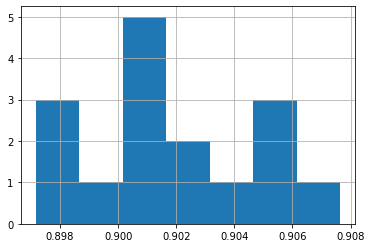

In [166]:
plt.hist(cv_score_xgb, bins=7)
plt.grid()

In [167]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

Cross-validated Accuracy: 0.9019 ± 0.00295


Cross-validated Accuracy: 0.90101 ± 0.00426

In [168]:
y_train.value_counts()

Classification
3                 42480
0                  9575
2                  5152
1                   999
dtype: int64

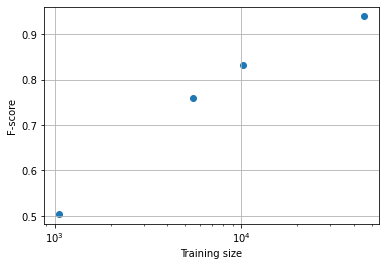

In [180]:
class_sizes = np.array([10186, 1062, 5514, 45325])
F_scores = np.array([0.8312, 0.5041, 0.7597, 0.9387])
plt.scatter(class_sizes, F_scores)
plt.xlabel("Training size")
plt.ylabel("F-score")
plt.grid()
plt.xscale("log")
plt.savefig("Sample_sizes.pdf")

In [16]:
test = [0.99 for i in range(99)]
test.append(0.01)
print("Data:", round(np.mean(test), 5), "±", round(np.std(test), 5))

Data: 0.9802 ± 0.09751


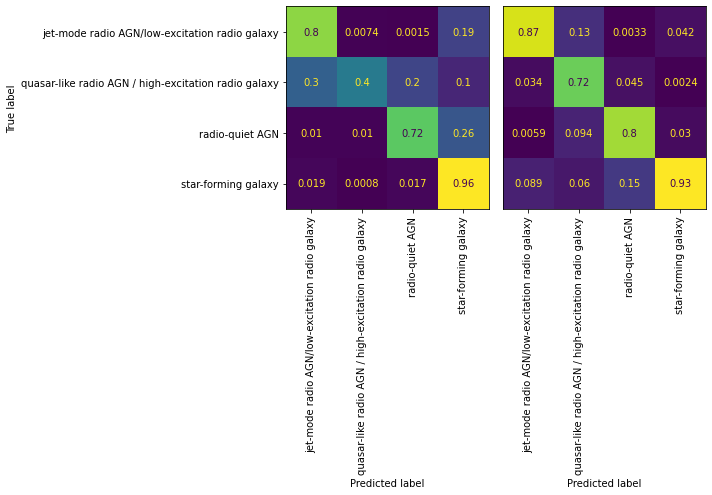

In [198]:
fig, axes = plt.subplots(1,2, figsize=(10,10))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=axes[0], colorbar=False)

cm = confusion_matrix(y_test, y_pred, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=axes[1], colorbar=False)
axes[1].axes.get_yaxis().set_visible(False)
for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.tight_layout()
plt.plot()
fig.savefig("Confusion.pdf")

## Redshift dependence

In [14]:
redshifts = X.iloc[X_train['Z_BEST'].index]['Z_BEST']

<AxesSubplot:>

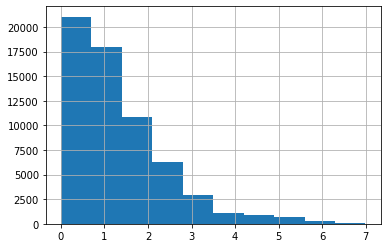

In [15]:
redshifts.hist()

In [43]:
accuracy_for_z_larger = []
accuracy_for_z_larger_std = []
z_range = [0,1,2,3,4]
for z in z_range:
    cv_score = cross_val_score(cross_val_model, X_train[redshifts>z], y_train[redshifts>z], cv=8, n_jobs=-1, scoring="accuracy")
    
    accuracy_for_z_larger.append(np.mean(cv_score))
    accuracy_for_z_larger_std.append(np.std(cv_score))

<ErrorbarContainer object of 3 artists>

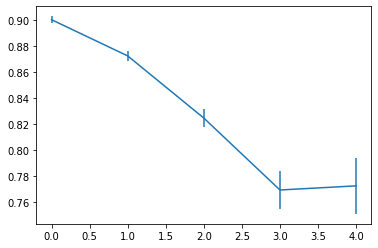

In [44]:
plt.errorbar(z_range, accuracy_for_z_larger, yerr=accuracy_for_z_larger_std)

In [17]:
accuracy_for_z_inbetween = []
accuracy_for_z_inbetween_std = []
z_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
for z in z_range:
    print(f"Working on redshift range {z}-{z+0.5}")
    filt = ((redshifts>z) & (redshifts<(z+0.5)))
    cv_score = cross_val_score(cross_val_model, X_train[filt], y_train[filt], cv=64, n_jobs=8, scoring="accuracy")
    
    accuracy_for_z_inbetween.append(np.mean(cv_score))
    accuracy_for_z_inbetween_std.append(np.std(cv_score))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5. ]
Working on redshift range 0.0-0.1
Working on redshift range 0.1-0.2
Working on redshift range 0.2-0.30000000000000004
Working on redshift range 0.30000000000000004-0.4
Working on redshift range 0.4-0.5
Working on redshift range 0.5-0.6
Working on redshift range 0.6000000000000001-0.7000000000000001
Working on redshift range 0.7000000000000001-0.8
Working on redshift range 0.8-0.9
Working on redshift range 0.9-1.0
Working on redshift range 1.0-1.1
Working on redshift range 1.1-1.2000000000000002
Working on redshift range 1.2000000000000002-1.3000000000000003
Working on redshift range 1.3-1.4000000000000001
Working on redshift range 1.4000000000000001-1.5000000000000002
Working on redshift range 1.5-1.6
Working on redshift range 1.6-1.7000000000000002
Working on redshift range 1.7000

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.3000000000000003-3.4000000000000004


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.4000000000000004-3.5000000000000004


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.5-3.6
Working on redshift range 3.6-3.7


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.7-3.8000000000000003


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.8000000000000003-3.9000000000000004


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 3.9000000000000004-4.0


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.0-4.1


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.1000000000000005-4.2


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.2-4.3


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\Local

Working on redshift range 4.3-4.3999999999999995
Working on redshift range 4.4-4.5


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.5-4.6


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.6000000000000005-4.7


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.7-4.8


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=8.
  warnings.warn(


Working on redshift range 4.800000000000001-4.9


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\Local

Working on redshift range 4.9-5.0
Working on redshift range 5.0-5.1


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(


In [ ]:
counts = []
z_range_counts = np.linspace(0,5,100)
for z in z_range_counts:
    filt = ((redshifts>z) & (redshifts<(z+0.5)))
    counts.append(len(X_train[filt]))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(z_range, accuracy_for_z_inbetween, yerr=accuracy_for_z_inbetween_std, width=0.5, label='Accuracy')
ax.set_ylim(0.6,1)


ax.set_xticks(np.arange(-0.25,5.5,0.5))
ax.set_xticklabels(np.arange(0, 6, 0.5))
ax.grid()
ax.set_xlabel("Redshift")
ax.set_ylabel("Accuracy")


ax2=ax.twinx()
ax2.plot(z_range_counts, counts, c='r', label='Counts')
ax2.set_ylabel("Counts")
fig.legend()
plt.show()
fig.savefig("Redshifts.pdf")

In [76]:
accuracy_for_z_plus_1 = []
z_range = np.linspace(0,6,100)
for z in z_range:
    y_pred = model.predict(X_test[(redshifts_test>z) & (redshifts_test<(z+1))])
    accuracy_for_z_plus_1.append(accuracy_score(y_test[((redshifts_test>z) & (redshifts_test<(z+1)))], y_pred))

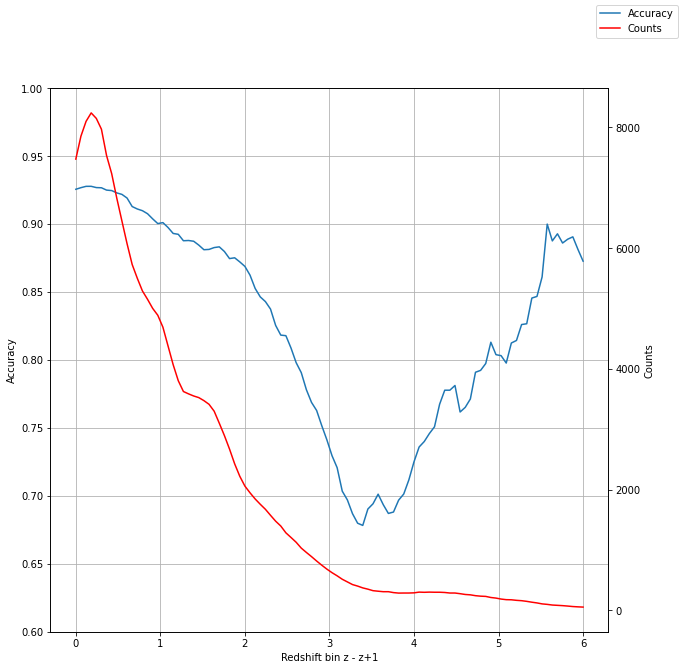

In [98]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(z_range, accuracy_for_z_plus_1, label='Accuracy')
ax.grid()
ax.set_xlabel("Redshift bin z - z+1")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.6,1)

ax2=ax.twinx()
ax2.plot(z_range, counts, c='r', label='Counts')
ax2.set_ylabel("Counts")
#ax2.xscale('log')
fig.legend()

## Feature relevance

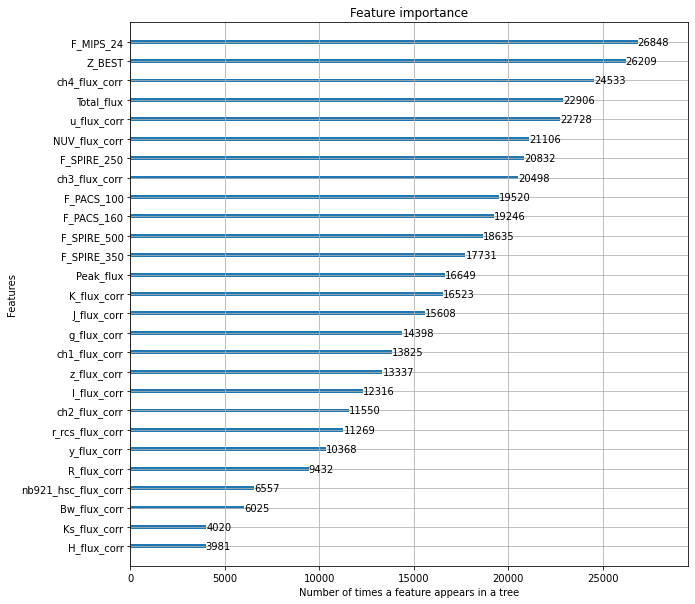

In [89]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax, importance_type='weight', xlabel='Number of times a feature appears in a tree')
fig.savefig("Feature_importance.pdf")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Average gain of splits which use the feature', ylabel='Features'>

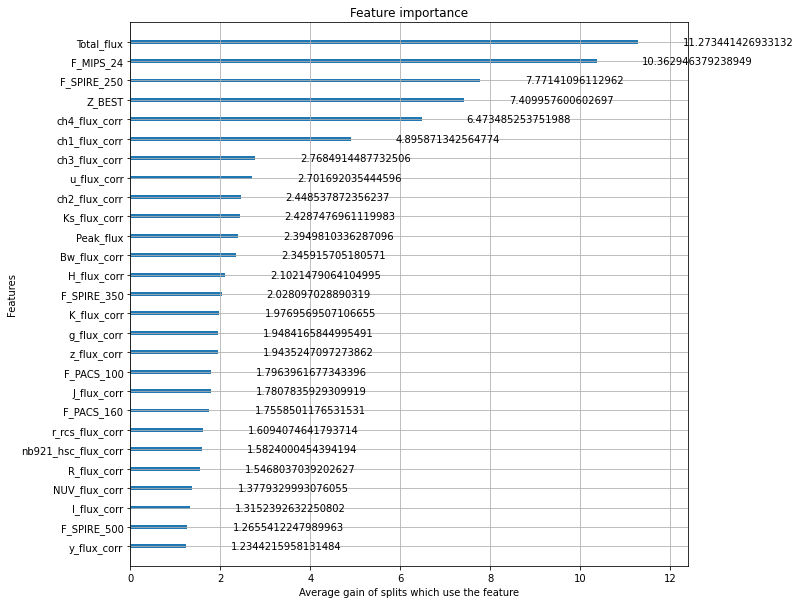

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax, importance_type='gain', xlabel='Average gain of splits which use the feature')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Average number of samples affected by the split by feature', ylabel='Features'>

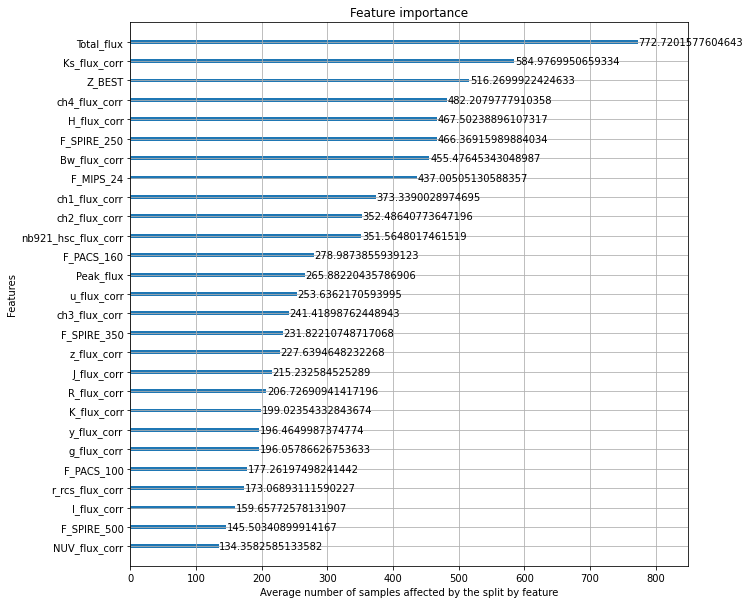

In [93]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax, importance_type='cover'
                    , xlabel='Average number of samples affected by the split by feature')

## Flag marking

In [215]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index, columns=['Prediction'])

In [216]:
Xray_all = []
opt_spec_all = []
ext_radio_all = []
IR_all = []
for j in range(4):
    for i in range(4):
        # Finding pandas dataframes for the squares in the confusion matrix
        cm_square = y_pred[(y_test['Classification']==j) & (y_pred['Prediction']==i)]
        flags = y_test_flags.loc[cm_square.index]

        # Finding frequencies of flags
        Xray_freq = sum(flags['Xray'])/len(flags['Xray'])
        opt_spec_freq = sum(flags['Opt_spec'])/len(flags['Opt_spec'])
        ext_radio_freq = sum(flags['Extended_radio'])/len(flags['Extended_radio'])
        IR_freq = sum(flags['IRAGN'])/len(flags['IRAGN'])

        Xray_all.append(Xray_freq)
        opt_spec_all.append(opt_spec_freq)
        ext_radio_all.append(ext_radio_freq)
        IR_all.append(IR_freq)

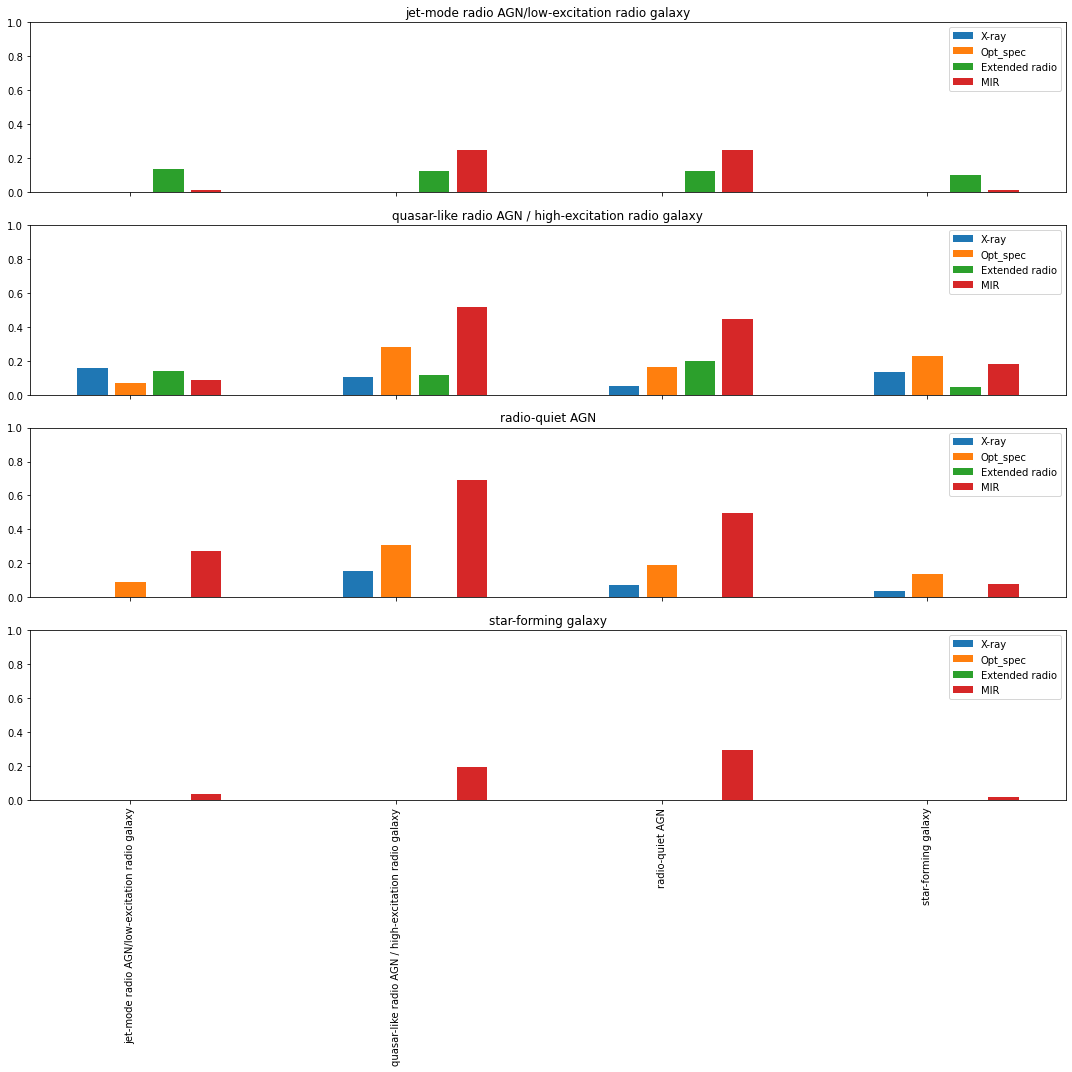

In [217]:
x = np.arange(0,26,7)
fig, axes = plt.subplots(4, 1, figsize=(15,15), sharex='all')
for i, ax in enumerate(axes):
    i0 = i*4
    i1 = (i+1)*4
    
    ax.bar(x, Xray_all[i0:i1], label='X-ray')
    # For setting the tick labels
    ax.bar(x+1, opt_spec_all[i0:i1], label='Opt_spec', tick_label=labels)
    ax.bar(x+2, ext_radio_all[i0:i1], label='Extended radio')
    ax.bar(x+3, IR_all[i0:i1], label='MIR')
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_title(f'{labels[i]}')
    ax.set_ylim(0,1)
    ax.legend()
plt.tight_layout()
fig.savefig('Flags.pdf')

In [169]:
5+5

10